In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
data = gpd.read_file(r'data_raw/ufb_rev_wald_teil.shp', encoding='utf-8')

In [3]:
data.head()

,KREIS_NAME,REVUFB_NM,REVUFBADR,NSW_FI,NSW_SONST,SW_FI,SW_SONST,geometry
0,Mittelsachsen,Reinsberg,2203,1597.32,3274.630917,2706.18,2133.910411,"POLYGON ((386902.476 5656907.025, 386910.595 5..."
1,Mittelsachsen,Geringswalde,2201,841.61,3508.605810,196.15,1453.972847,"POLYGON ((332902.962 5650328.573, 332905.989 5..."
2,Leipzig,Leipziger Land,2902,401.71,8199.853850,615.51,5314.476829,"POLYGON ((332897.160 5650325.466, 332893.592 5..."
3,Mittelsachsen,Striegistal,2202,954.18,3156.650864,1147.04,1844.186239,"MULTIPOLYGON (((377509.195 5657427.330, 377569..."
4,Meißen,Süd,2703,392.75,4365.001441,381.91,1973.920712,"POLYGON ((377329.166 5657157.286, 377285.838 5..."


In [4]:
kreis_data = data.dissolve(by='KREIS_NAME')
kreis_data.reset_index(inplace=True)

In [5]:
for dataset in [data, kreis_data]:
    dataset['coords'] = dataset['geometry'].apply(lambda x: x.representative_point().coords[:])
    dataset['coords'] = [coords[0] for coords in dataset['coords']]

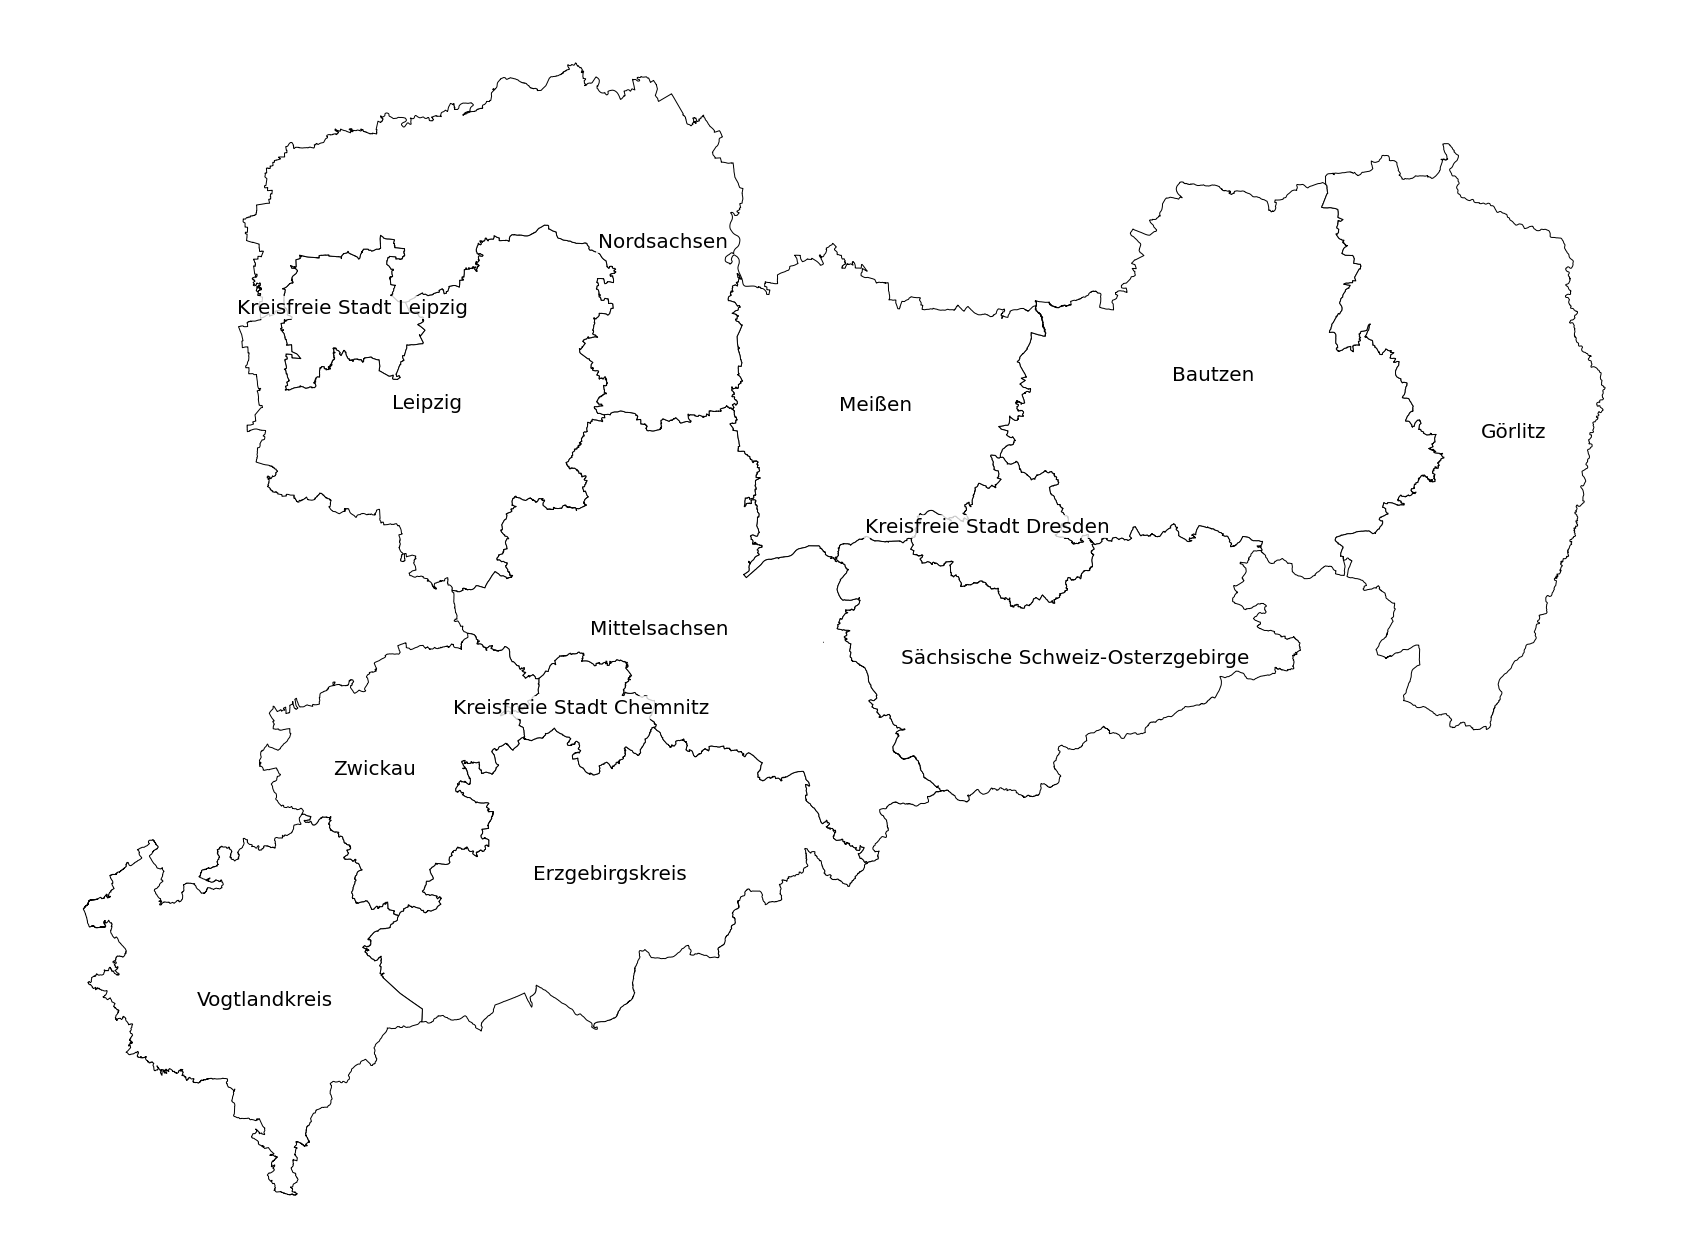

In [6]:
fig, ax = plt.subplots(figsize=(30,30))
kreis_data.plot(ax=ax, legend=True, color='white',
                edgecolor='black', linewidth=1)
for idx, row in kreis_data.iterrows():
    ax.text(row.coords[0], row.coords[1], fontsize=20,
            s=row['KREIS_NAME'], horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})
    
plt.axis('off');

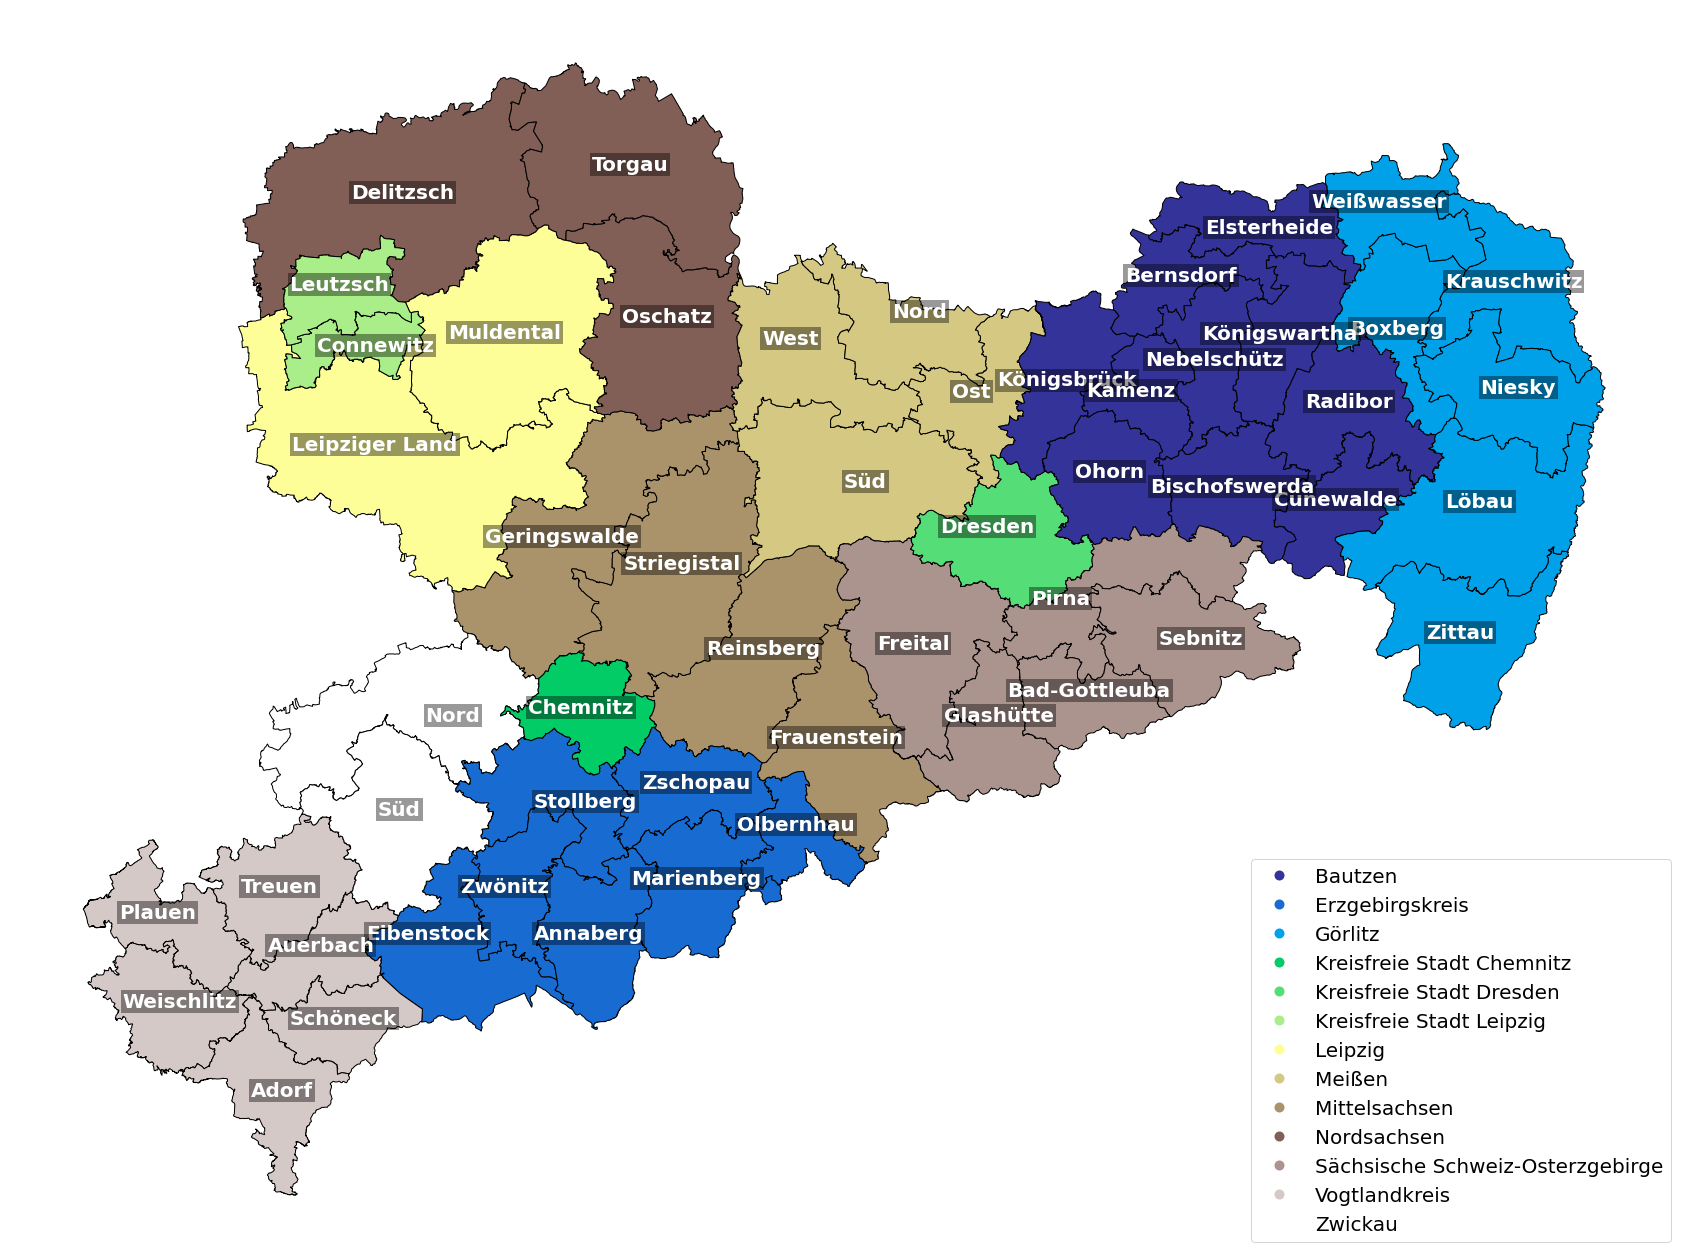

In [7]:

fig, ax = plt.subplots(figsize=(30,30))
data.plot(ax=ax, column='KREIS_NAME', legend=True,
          edgecolor='black', linewidth=1, 
          cmap='terrain', legend_kwds={'fontsize': 20, 'loc': 'lower right'})

for idx, row in data.iterrows():
    ax.text(row.coords[0], row.coords[1], color='white', weight = 'bold', fontsize=20,
            s=row['REVUFB_NM'], horizontalalignment='center', 
            bbox={'facecolor': 'black', 'alpha':0.4, 'pad': 2, 'edgecolor':'none'})
    

plt.axis('off');

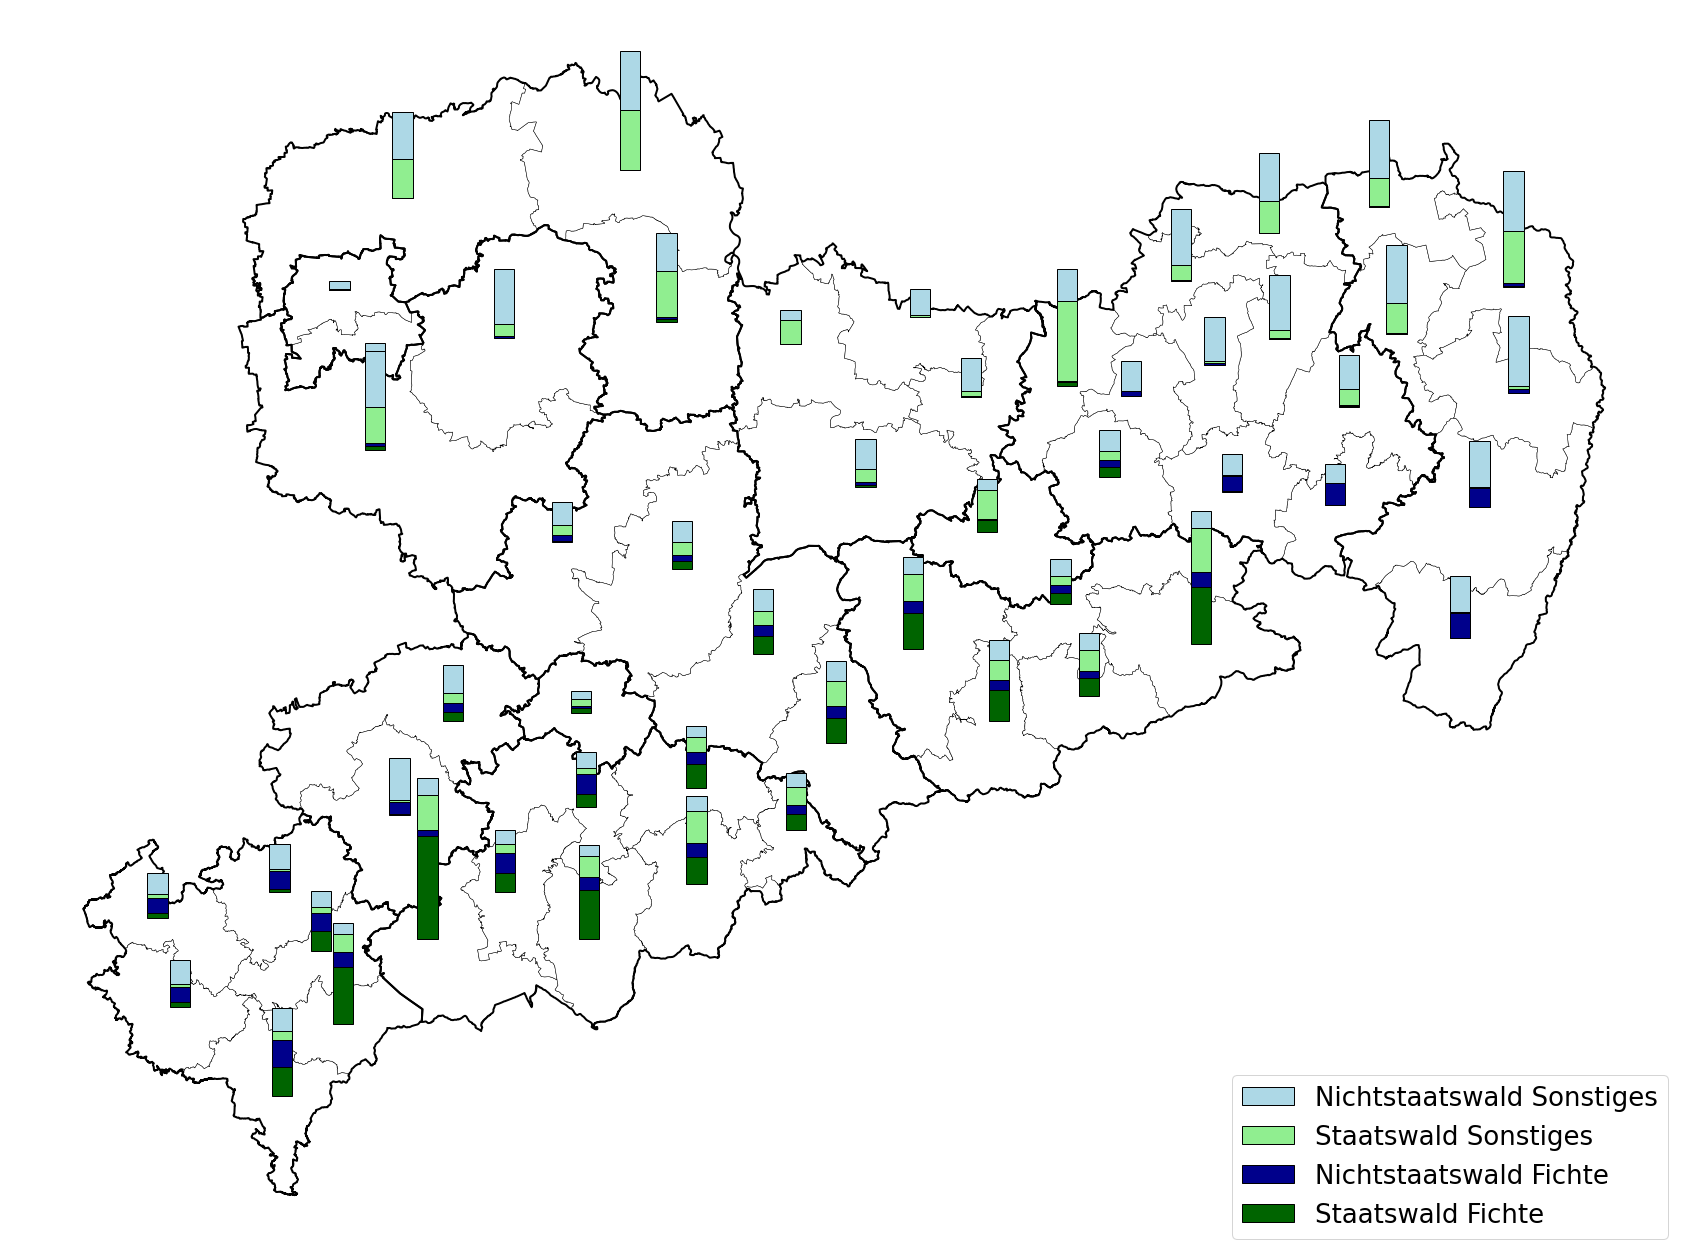

In [8]:
fig, ax = plt.subplots(figsize=(30,30))
data.plot(ax=ax, legend=True, color='white',
                edgecolor='black', linewidth=0.5)

kreis_data.plot(ax=ax, legend=True, color='none',
                edgecolor='black', linewidth=2)

width = 3000
colors = ['darkgreen', 'darkblue', 'lightgreen', 'lightblue']

for idx, row in data.iterrows():
    sw_fi = patches.Rectangle((row['coords'][0]-width/2, 
                                row['coords'][1]), 
                             width=width, height=row['SW_FI'], 
                              color=colors[0], ec='black'
                             )
    
    nsw_fi = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI']), 
                             width=width, height=row['NSW_FI'], 
                               color=colors[1], ec='black'
                              )
    
    sw_sonst = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI'] + row['NSW_FI']), 
                             width=width, height=row['SW_SONST'], 
                                 color=colors[2], ec='black'
                                )
    
    nsw_sonst = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI'] + row['NSW_FI'] + row['SW_SONST']), 
                             width=width, height=row['NSW_SONST'], 
                                  color=colors[3], ec='black'
                                 )
    
    ax.add_patch(sw_fi)
    ax.add_patch(nsw_fi)
    ax.add_patch(sw_sonst)
    ax.add_patch(nsw_sonst)
    
    
plt.legend(handles=[patches.Patch(color=colors[3], label='Nichtstaatswald Sonstiges', ec='black'),
                    patches.Patch(color=colors[2], label='Staatswald Sonstiges', ec='black'),
                    patches.Patch(color=colors[1], label='Nichtstaatswald Fichte', ec='black'),
                    patches.Patch(color=colors[0], label='Staatswald Fichte', ec='black')],
          fontsize=26, loc='lower right')
plt.axis('off');

In [9]:
data.crs

{'init': 'epsg:25833'}

In [19]:
import rasterio # the GEOS-based raster package
import rasterio.plot
import rasterstats
raster = rasterio.open(r'data_raw/climate/GRID_1_Messungen_Tageswerte_2020_TM0_TW_20050315_utm.asc', nodata=-9999.0)

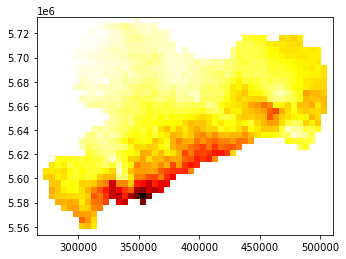

In [15]:
rasterio.plot.show(raster, cmap='hot')

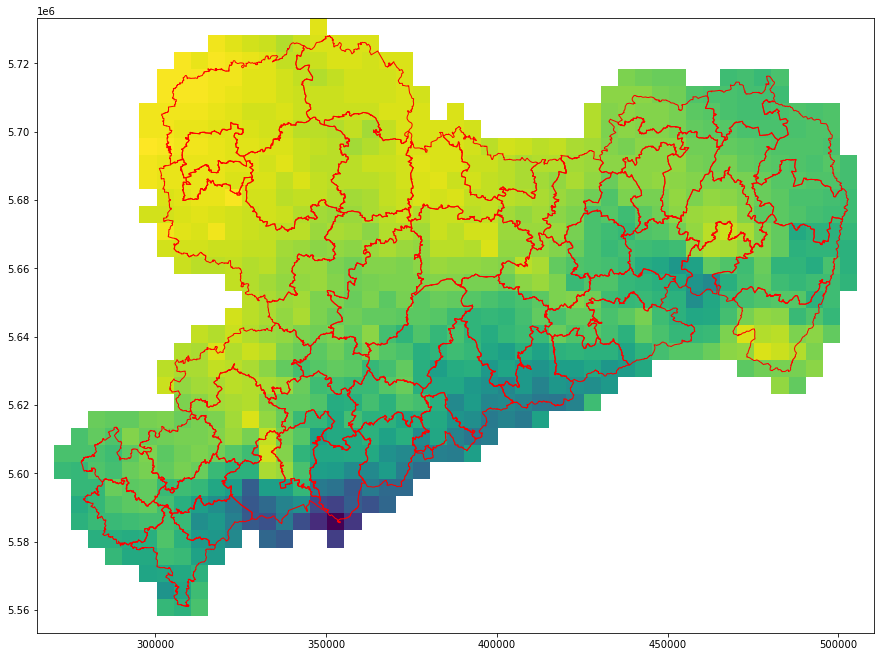

In [16]:
fig, ax = plt.subplots(figsize=(15, 25))
rasterio.plot.show(raster, ax=ax)
data.plot(ax=ax, facecolor='none', edgecolor='red')

In [90]:
rasterband = raster.read(1)
transform = raster.transform
rasterstats.zonal_stats(data.geometry.iloc[0], rasterband, affine=transform, nodata=-9999.0, stats='min')

[{'min': 3.5}]

In [33]:
data.iloc[0]

KREIS_NAME                                        Mittelsachsen
REVUFB_NM                                             Reinsberg
REVUFBADR                                                  2203
NSW_FI                                                  1597.32
NSW_SONST                                               3274.63
SW_FI                                                   2706.18
SW_SONST                                                2133.91
geometry      POLYGON ((386902.4758000001 5656907.0252, 3869...
coords                         (378657.9931912744, 5640906.683)
Name: 0, dtype: object

In [88]:
np.unique(raster.read(1))

array([-9.999e+03, -2.000e+00, -9.000e-01, -6.000e-01, -4.000e-01,
       -3.000e-01,  0.000e+00,  1.000e-01,  2.000e-01,  4.000e-01,
        5.000e-01,  6.000e-01,  9.000e-01,  1.000e+00,  1.300e+00,
        1.400e+00,  1.500e+00,  1.600e+00,  1.700e+00,  1.800e+00,
        1.900e+00,  2.000e+00,  2.100e+00,  2.200e+00,  2.300e+00,
        2.400e+00,  2.500e+00,  2.600e+00,  2.700e+00,  2.800e+00,
        2.900e+00,  3.000e+00,  3.100e+00,  3.200e+00,  3.300e+00,
        3.400e+00,  3.500e+00,  3.600e+00,  3.700e+00,  3.800e+00,
        3.900e+00,  4.000e+00,  4.100e+00,  4.200e+00,  4.300e+00,
        4.400e+00,  4.500e+00,  4.600e+00,  4.700e+00,  4.800e+00,
        4.900e+00,  5.000e+00,  5.100e+00,  5.200e+00,  5.300e+00,
        5.400e+00,  5.500e+00,  5.600e+00,  5.700e+00,  5.800e+00,
        5.900e+00,  6.000e+00,  6.100e+00,  6.200e+00,  6.300e+00,
        6.400e+00,  6.500e+00,  6.600e+00,  6.700e+00], dtype=float32)

In [84]:
bbox = data[data['REVUFB_NM'] == 'Adorf'].total_bounds
window = raster.window(*bbox)
raster_adorf = raster.read(1, window=window)
raster_adorf

array([[ 4.100e+00,  4.100e+00,  3.900e+00,  2.300e+00],
       [ 3.500e+00,  4.300e+00,  3.600e+00,  2.700e+00],
       [ 3.300e+00,  4.000e+00,  3.900e+00,  3.000e+00],
       [ 3.100e+00,  3.200e+00,  3.300e+00,  3.600e+00],
       [-9.999e+03,  2.500e+00,  3.100e+00,  4.000e+00]], dtype=float32)

(5561086.575999999, 5590353.316)

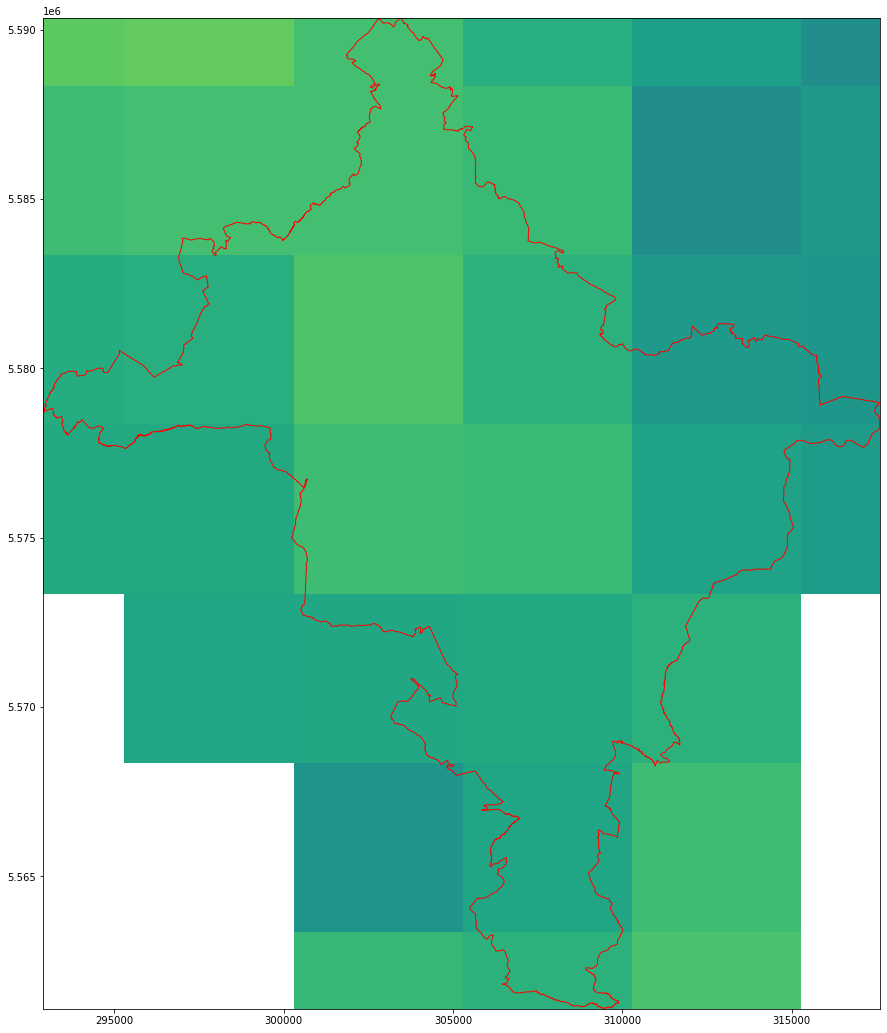

In [83]:
# nur einen Ausschnitt plotten
bbox = data[data['REVUFB_NM'] == 'Adorf'].total_bounds

fig, ax = plt.subplots(figsize=(15, 25))
rasterio.plot.show(raster, ax=ax)
data[data['REVUFB_NM'] == 'Adorf'].plot(ax=ax, facecolor='none', edgecolor='red')

ax.set_xlim([bbox[0],  bbox[2]])
ax.set_ylim([bbox[1],  bbox[3]])